In [5]:
# will autoupdate any of the packages imported:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy
from context import *

# Spectrum Bifurcation Renormalization Group (SBRG)

Spectrum bifurcation renormalization group (SBRG) is an approximate method to diagonalize strongly disordered Pauli Hamiltonians by Clifford unitary transformations [arXiv:1508.03635](https://arxiv.org/abs/1508.03635). Given a many-body Hamiltonian $H=\sum_a h_a P_a$ as a linear combination of a (sparse) set of Pauli operators $P_a$, the SBRG finds an approximate Clifford circuit $U$, such that the transformed Hamiltonian takes the diagonal form

$$H_\text{eff}=U^\dagger HU\simeq \sum_{i}\epsilon_{i} Z_i+\sum_{ij}\epsilon_{ij}Z_i Z_j+\sum_{ijk}\epsilon_{ijk}Z_i Z_j Z_k+\cdots$$

This is a strong disorder renormalization group method, which relies on the strong randomness of the Hamiltonian coefficients $h_a$, such that different terms in the Hamiltonian have seperating energy scales. 

For example, consider a two-qubit test Hamiltonian as follows. Here $Z_0Z_1$ is a leading term and $X_0$, $X_1$ are treated as perturbations. 

In [3]:
H = - paulialg.pauli('ZZ') + 0.2 * paulialg.pauli('XI') + 0.1 * paulialg.pauli('IX')

Use SBRG to find the effective Hamiltonian and the Clifford unitary circuit that approximately diagonalizes the Hamiltonian.

In [4]:
Heff, U = circuit.SBRG(H)
Heff

0.02 IZ +1.02 ZI

One can check the accracy of $H_\text{eff}$ by comparing its eigenvalues with those of $H$ by exact diagonalization.

In [5]:
numpy.linalg.eigvalsh(H.to_qutip())

array([-1.04403065, -1.00498756,  1.00498756,  1.04403065])

In [6]:
numpy.linalg.eigvalsh(Heff.to_qutip())

array([-1.045, -1.005,  1.005,  1.045])

One can see that the eigenvalues matches to the 2nd order of perturbations as expected.

Consider a larger example of diagonalizing random transverse field Ising model Hamiltonian by the SBRG algorithm.

In [45]:
N = 16
H = paulialg.pauli_zero(N)
for i in range(N):
    H += numpy.random.randn() * paulialg.pauli({i:'Z',(i+1)%N:'Z'}, N)
    H += numpy.random.randn() * paulialg.pauli({i:'X'}, N)
H

-0.18 IIIIIIIIIIIIIIIX -1.06 IIIIIIIIIIIIIIZZ +1.62 IIIIIIIIIIIIIIXI +0.02 IIIIIIIIIIIIIZZI +0.43 IIIIIIIIIIIIIXII -1.70 IIIIIIIIIIIIZZII +0.56 IIIIIIIIIIIIXIII +0.50 IIIIIIIIIIIZZIII +0.21 IIIIIIIIIIIXIIII +0.92 IIIIIIIIIIZZIIII -2.35 IIIIIIIIIIXIIIII +2.32 IIIIIIIIIZZIIIII -0.11 IIIIIIIIIXIIIIII -0.87 IIIIIIIIZZIIIIII +0.50 IIIIIIIIXIIIIIII +1.42 IIIIIIIZZIIIIIII +0.39 IIIIIIIXIIIIIIII +1.03 IIIIIIZZIIIIIIII -0.11 IIIIIIXIIIIIIIII -0.45 IIIIIZZIIIIIIIII +1.99 IIIIIXIIIIIIIIII -0.59 IIIIZZIIIIIIIIII +1.21 IIIIXIIIIIIIIIII +0.81 IIIZZIIIIIIIIIII +0.44 IIIXIIIIIIIIIIII -0.39 IIZZIIIIIIIIIIII -0.95 IIXIIIIIIIIIIIII -0.85 IZZIIIIIIIIIIIII -0.88 IXIIIIIIIIIIIIII -1.80 ZIIIIIIIIIIIIIIZ +0.49 ZZIIIIIIIIIIIIII +1.15 XIIIIIIIIIIIIIII

Many-body localization effective Hamiltonian.

In [46]:
Heff, U = circuit.SBRG(H)
Heff

-0.87 IIIIIIIZIZIZIIII +1.56 IIIIIZIIIIIIIIII +1.04 IIIIIZIZIIIIIIII +1.97 IIIIZIIIIIIIIIII -1.49 IIIIZIZIIIIIIIII -1.85 IIIZIIIIIIIIIIII +0.49 IIIZIIIIIIIIZZII -0.52 IIIZIIIIIIIZZIII -2.18 IIZIIIIIIIIIIIII +1.41 IIZIIIIIZIIIIIII +2.13 IZIIIIIIIIIIIIII +1.08 IZIIIIIZIIZIIIII -3.67 ZIIIIIIIIIIIIIII +0.94 ZIIIIIIIIZIIIIII -0.00 ZIIZIZZZIZZZIZZZ -0.12 ZIZIIIIIZIIIIIZI -0.00 ZIZZIIZZIIZIIZZI

A representative approximate eigenstate (in the original basis).

In [47]:
rho = U.backward(stabilizer.zero_state(N))
rho

StabilizerState(
   +IIIIIIIIIIXIIIII
   +IIIIIXIIIIIIIIII
   +ZIIIIIIIIIIIIIIZ
   +IIIIIIIIIIIIZZII
   +IIIIIIIIIIIIIIXI
   +IIIIIIIZZIIIIIII
   -IIIIXIIIIIIIIIXI
   +IIIIIIZIZIIIIIII
   -ZIXIIIIIIIIIIIIZ
   -IIIIIIIIIZIZIIII
   -IXIIIXZIZIIIIIII
   -IIIIIIZIIIIZIIII
   +IIIIIIZIIIIIIZII
   +IIIXIIZIIIIIZIII
   -YIXIIIIIIIXIIIIY
   -YXXXXXYYYYXXXXXY)

Half-system-size entanglement entropy (in unit of bit) of the state.

In [48]:
rho.entropy(numpy.arange(N//2))

2

Perform the calculation of entanglement entropy over different sizes of entanglement regions for eigenstates of different random Hamiltonians.

In [53]:
N = 128
Ls = numpy.arange(N//2)
S_lst =[]
samples = 20
for _ in range(samples):
    H = paulialg.pauli_zero(N)
    for i in range(N):
        H += numpy.random.randn() * paulialg.pauli({i:'Z',(i+1)%N:'Z'}, N)
        H += numpy.random.randn() * paulialg.pauli({i:'X'}, N)
    Heff, U = circuit.SBRG(H)
    rho = U.backward(stabilizer.zero_state(N))
    S_lst.append(numpy.array([[rho.entropy((i + numpy.arange(L)) % N) for i in range(N)] for L in Ls]).mean(1))
Ss = numpy.stack(S_lst).mean(0)
Serr = numpy.stack(S_lst).std(0)/numpy.sqrt(samples)

The entanglement entropy should scale logarithmically for random transverse field Ising model at the strong-disorder critical point.

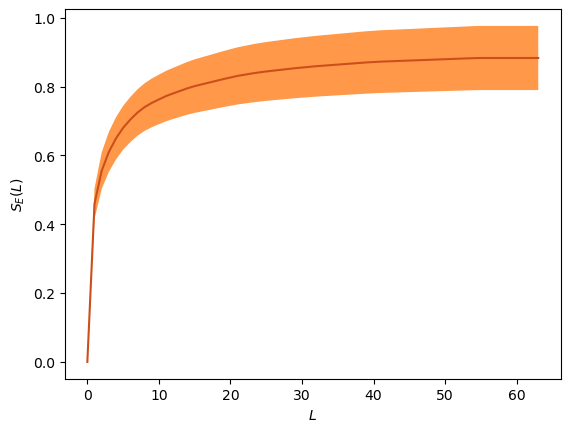

In [54]:
import matplotlib.pyplot as plt
plt.plot(Ls, Ss,  color='#CC4F1B')
plt.fill_between(Ls, Ss-Serr, Ss+Serr, facecolor='#FF9848')
plt.xlabel('$L$'); plt.ylabel('$S_E(L)$');